# Forward & Inverse modelling 2D ERT with pyGimli
## Layered Earth example

Here we take a look at forward modelling a layered earth, then inverting the forward modelling result first without
constraints, then with some layer definitions. With much thanks to the folks behind [pyGimli](https://www.pygimli.org/).

First, load up some packages. We need to have pygimli & numpy in addition to standard python installation, and reference
the exampledata folder if we want to pick up field data for electrode configurations.

In [2]:
import pygimli as pg
import numpy as np
from pygimli.physics import ert
import pygimli.meshtools as mt

datafolder = "..\\exampledata\\Lubango\\"

## Create the electrode scheme and model

Firstly, create a 'scheme' of electrode locations to integrate into the world mesh later.

The code below shows, firstly, a simulated 21-point dipole-dipole (`dd`) array of electrodes every 5m from `x=0` to `x=100`. Alternately, we can load example data, and load the electrode locations & spacing. Note that this option is probably not highly robust; likely works with any bert format files, but might fall down if electrode spacing is variable.

The `maxSeparation` argument is used to limit spread between AB and MN centres (otherwise scheme will include all possible pairs out to the full line length, which is unusual). This limiting can also be achieved later by limiting the geometric factor, `k`, but that is less intuitive.

Other preset configurations include Wenner, `'wa'`, Schlumberger `'slm'` and pole-dipole `'pd'`. To trigger a list, run the
cell with the `schemeName` set to an unrecognised scheme, e.g. `'abc'`.

In [3]:
# Option to create 'synthetic' electrode scheme
# elecs=np.linspace(start=0, stop=100, num=21, maxSeparation=10)

# Option to use scheme from field data...
data = ert.load(datafolder + "DD_5-1.ohm") 
elecs=pg.x(data)

# Create electrode 'scheme'
scheme = ert.createData(elecs=elecs, schemeName='dd', maxSeparation=20)


Next, create a 'world' (with optional layers, bodies, etc) and display it. This currently creates a 'world' with limits based on the `elecs` variable above, with 2 layers at 2 x electrode spacing, and 3.5 x electrode spacing (depths from surface) overlying a halfspace.

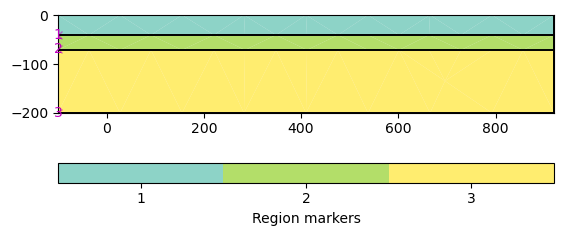

In [4]:
spacing = (max(elecs) - min(elecs))/(len(elecs) -1)

world = mt.createWorld(start=[min(elecs)-5*spacing, 0.], 
                       end=[max(elecs)+5*spacing, -10*spacing],
                       layers=[-2*spacing, -3.5*spacing], worldMarker=True)
pg.show(world);

It's also possible to define circles, rectangles and polygons with the pygimli meshtools, then add them to the 'world' 
arithmetically, e.g. `world += block`, or to add sloping lines to define dipping interfaces. More details of arguments at [pygimli.meshtools](https://www.pygimli.org/pygimliapi/_generated/pygimli.meshtools.html#module-pygimli.meshtools) and some examples of adding lines to a 'world' later in this notebook.

Some examples:
```
ball = mt.createCircle(pos=[25, -3.], radius=[4, 1], marker=4, boundaryMarker=10, area=0.1)

poly = mt.createPolygon([(11,-4), (12,-1.5), (14,-2), (15,-2), (18,-3), (15,-3.5), (13,-4.5)],
                        isClosed=True, addNodes=3, interpolate='spline', marker=5)
                        
block = mt.createRectangle(start = [55,-4], end = [60,-10], marker=6)
```

## Create mesh for earth model & electrode locations

Next, create the mesh within the 'world' for the earth model. The electrode scheme defines nodes in the mesh (with additional
nodes at 1/10 spacing on recommendations from pyGimli devs). We then define a resistivity mapping for the three layers, and 
display the model.

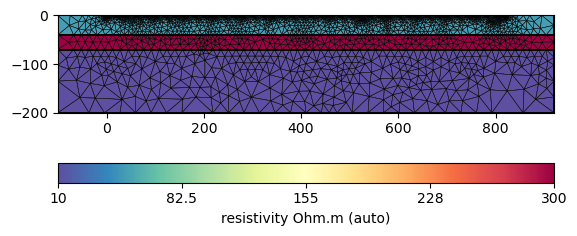

In [6]:
for p in scheme.sensors():
    world.createNode(p)
    world.createNode(p - [0, 0.1])

mesh = mt.createMesh(world, quality=34)

rhomap = [[1,50.],[2,300.],[3,10.]]

ax, _ = pg.show(mesh, data=rhomap, label=pg.unit('resistivity Ohm.m'),
                showMesh=True, cMap="Spectral_r")
ax.set_ylim(-10*spacing,0);

## Run the forward model & display result

18/07/24 - 09:53:19 - pyGIMLi - INFO - Data error estimate (min:max)  0.010007642539426403 : 0.02192904778025015
18/07/24 - 09:53:19 - pyGIMLi - INFO - 0.30424426853561726 1718.8885818343513
18/07/24 - 09:53:19 - pyGIMLi - INFO - Simulated data Data: Sensors: 42 data: 590, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
18/07/24 - 09:53:19 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
18/07/24 - 09:53:19 - pyGIMLi - INFO - Simulated rhoa (min/max) 46.77737598368813 87.89856506344829
18/07/24 - 09:53:19 - pyGIMLi - INFO - Selected data noise %(min/max) 1.0007642539426405 2.192904778025015


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


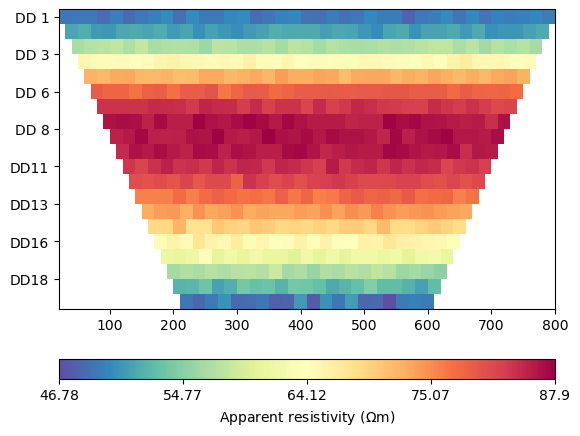

In [5]:
fwddata = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337);

# set information fields
pg.info(np.linalg.norm(fwddata['err']), np.linalg.norm(fwddata['rhoa']))
pg.info('Simulated data', fwddata)
pg.info('The data contains:', fwddata.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(fwddata['rhoa']), max(fwddata['rhoa']))
pg.info('Selected data noise %(min/max)', min(fwddata['err'])*100, max(fwddata['err'])*100)

ert.show(fwddata);

Show geometric factors, for reference/information value. Can be useful for limiting maximum AB-MN separation if this is not done with `maxSeparation` earlier in producing the electrode scheme.

590 [-376.99111843077515,...,-580566.3223834158]


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x274b4049b10>)

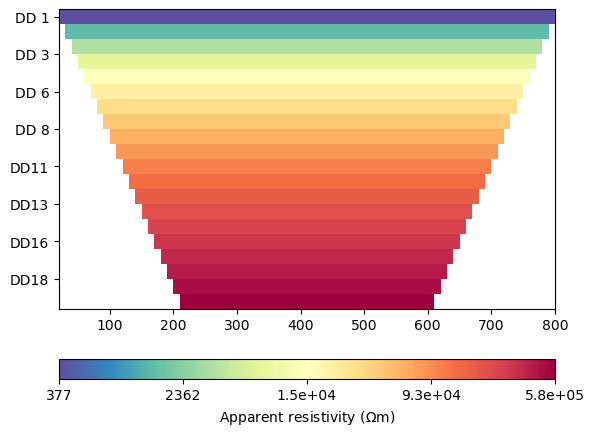

In [6]:
print(fwddata['k'])
#fwddata.remove(-fwddata['k'] > 400000)
ert.show(fwddata, -fwddata['k'], logScale=True)

## Run inversion of forward modelled output

First inversion test is completely open with automated mesh definition, and no constraints. With this earth model, it may be worthwhile to emphasis layering by adjusting the `zWeight`. We'll try that option following...

18/07/24 - 09:57:30 - pyGIMLi - INFO - Found 2 regions.
18/07/24 - 09:57:30 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/07/24 - 09:57:30 - pyGIMLi - INFO - Found 2 regions.
18/07/24 - 09:57:30 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
18/07/24 - 09:57:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/07/24 - 09:57:30 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/07/24 - 09:57:30 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1936 Cells: 3628 Boundaries: 2842
18/07/24 - 09:57:30 - pyGIMLi - INFO - Use median(data values)=72.0730128513454
18/07/24 - 09:57:30 - pyGIMLi - INFO - Created startmodel from forward operator: 680, min/max=72.073013/72.073013
18/07/24 - 09:57:30 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000274CB9D0950>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000274CBE2D4E0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000274B2750590>
min/max (data): 46.78/87.9
min/max (error): 1%/2.19%
min/max (start model): 72.07/72.07
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  319.83
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   36.12 (dPhi = 88.33%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   12.46 (dPhi = 60.99%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    1.09 (dPhi = 77.09%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.03 (dPhi = 1.82%) lam: 20.0
###########

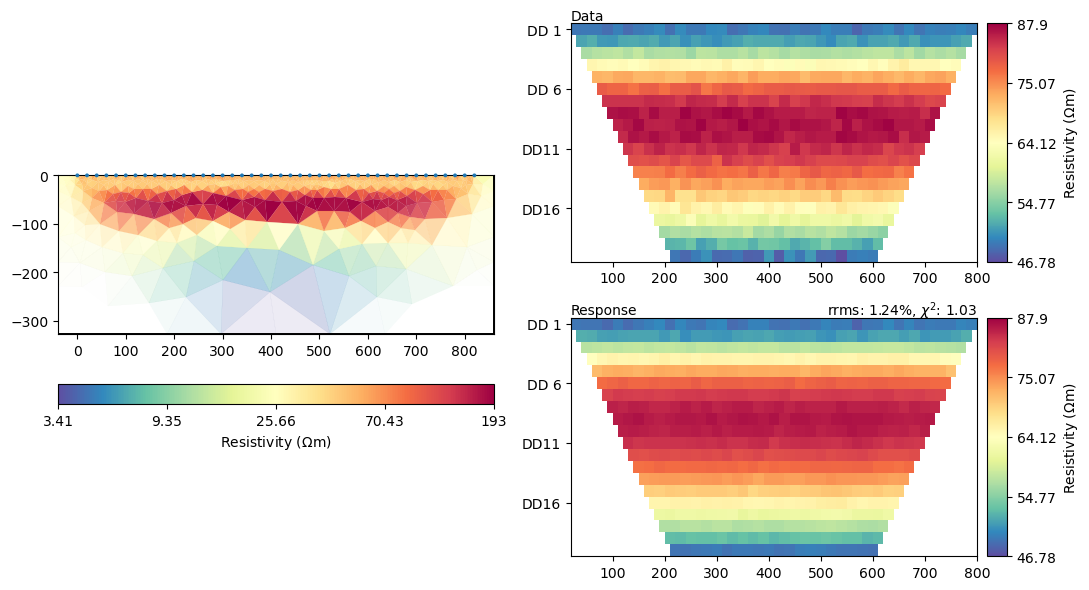

In [13]:
mgr = ert.ERTManager(fwddata);

inv = mgr.invert(lam=20, verbose=True, zWeight=1);
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1) # Not sure what this does, taken from pyGimli example

# plot inversion result with input/output pseudosections
mgr.showResultAndFit();

# plot just inversion result with fixed axis limits
# ax, _ = mgr.showResult(xlabel="x (m)", ylabel="z (m)", cMap="Spectral_r")
# ax.set_xlim(-10,110)

Now, a very similar unconstrained inversion but using a low value of `zWeight` that allows for better characterising the layered earth model.

18/07/24 - 09:53:30 - pyGIMLi - INFO - Use median(data values)=72.0730128513454
18/07/24 - 09:53:30 - pyGIMLi - INFO - Created startmodel from forward operator: 680, min/max=72.073013/72.073013
18/07/24 - 09:53:30 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000274B2770C20>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000274CB74DE40>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x00000274BDB9D380>
min/max (data): 46.78/87.9
min/max (error): 1%/2.19%
min/max (start model): 72.07/72.07
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  319.83
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   53.44 (dPhi = 83.25%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   27.68 (dPhi = 48.11%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   19.75 (dPhi = 28.39%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.03 (dPhi = 94.04%) l

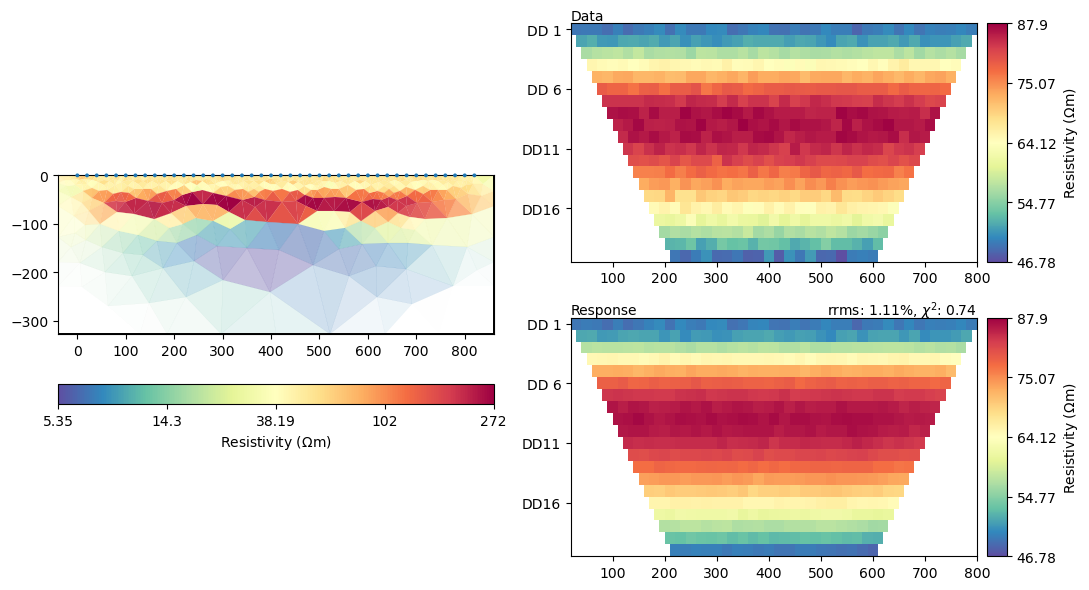

In [8]:
#mgr = ert.ERTManager(fwddata);

invLowz = mgr.invert(lam=20, verbose=True, zWeight=0.1);
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.7, significant=1) # Not sure what this does, taken from pyGimli example

# plot inversion result with input/output pseudosections
mgr.showResultAndFit();

# plot just inversion result with fixed axis limits
# ax, _ = mgr.showResult(xlabel="x (m)", ylabel="z (m)", cMap="Spectral_r")
# ax.set_xlim(-10,110)

## Inversion with layer boundaries

If we have confidence on the depth of layer interfaces, we can include them in the definition of a mesh for the inversion,
with dramatic results.

Create a similar 'world' with two horizontal lines:

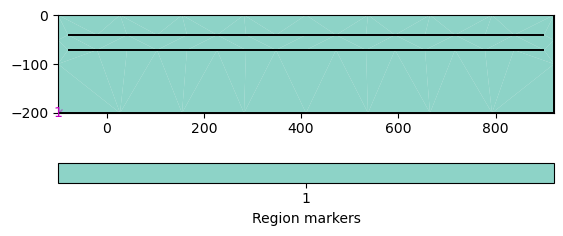

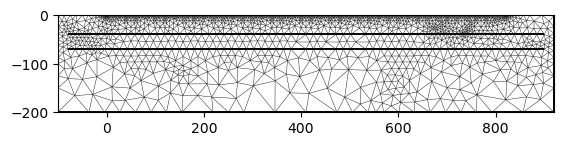

In [9]:
geo = mt.createWorld(start=[min(elecs)-5*spacing, 0.], 
                     end=[max(elecs)+5*spacing, -10*spacing],
                     worldMarker=True)

line1 = pg.meshtools.createLine(start=[min(elecs)-4*spacing, -2.*spacing],
                                end=[max(elecs)+4*spacing, -2.*spacing],
                                marker=2) # marker>0 means it functions as a constraint
line2 = pg.meshtools.createLine(start=[min(elecs)-4*spacing, -3.5*spacing],
                                end=[max(elecs)+4*spacing, -3.5*spacing],
                                marker=3) # marker>0 means it functions as a constraint

geo += line1 + line2

pg.show(geo)

for p in scheme.sensors():
    geo.createNode(p)
    geo.createNode(p - [0, 0.5])

invmesh = pg.meshtools.createMesh(geo, quality=34)
ax, _ = pg.show(invmesh)
#ax.set_xlim(min(elecs)-5*spacing, max(elecs)+5*spacing);
#ax.set_ylim(-10*spacing, 0);

Now re-run the inversion and display...

18/07/24 - 09:53:41 - pyGIMLi - INFO - Found 1 regions.
18/07/24 - 09:53:41 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/07/24 - 09:53:41 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
18/07/24 - 09:53:41 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 8992 Cells: 16844 Boundaries: 13202
18/07/24 - 09:53:42 - pyGIMLi - INFO - Use median(data values)=72.0730128513454
18/07/24 - 09:53:42 - pyGIMLi - INFO - Created startmodel from forward operator: 4211, min/max=72.073013/72.073013
18/07/24 - 09:53:42 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000274CBD5AED0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000274CBDEB9C0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000274CC508270>
min/max (data): 46.78/87.9
min/max (error): 1%/2.19%
min/max (start model): 72.07/72.07
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  319.83
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   47.25 (dPhi = 84.85%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =   27.30 (dPhi = 42.07%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =   21.18 (dPhi = 22.24%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =   17.83 (dPhi = 15.66%) lam: 20.0
----------

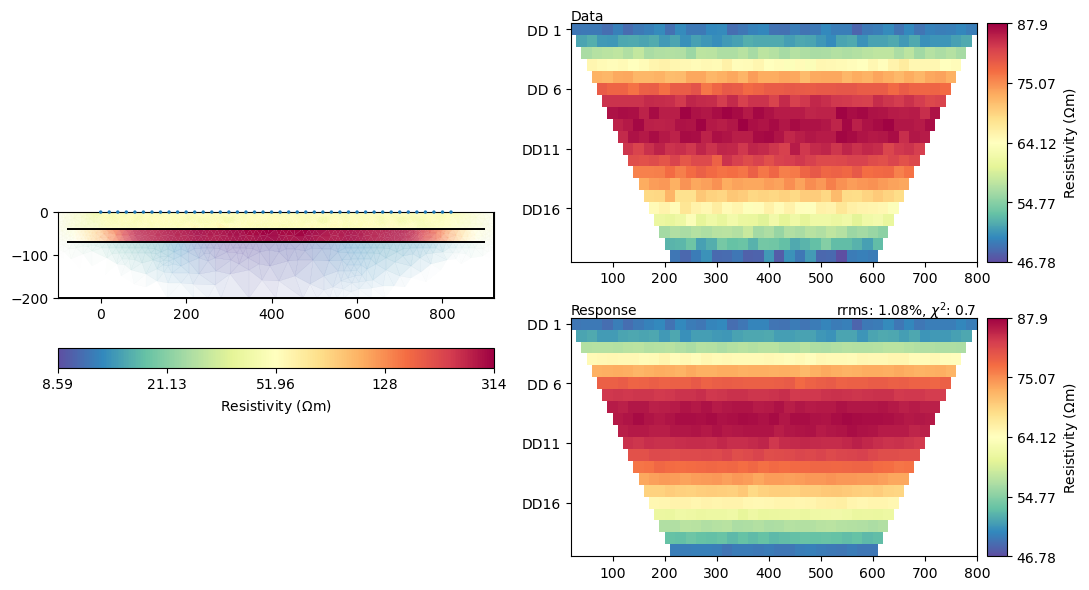

In [10]:
mgrConstrained = ert.ERTManager(fwddata)
coninv = mgrConstrained.invert(verbose=True, lam=20, mesh=invmesh)

mgrConstrained.showResultAndFit();

Finally, we can display the results from different options for the inversion, with the original 'world' first for comparison.

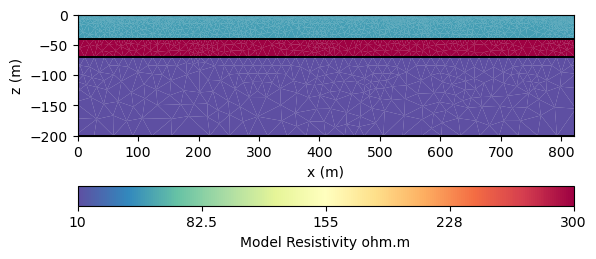

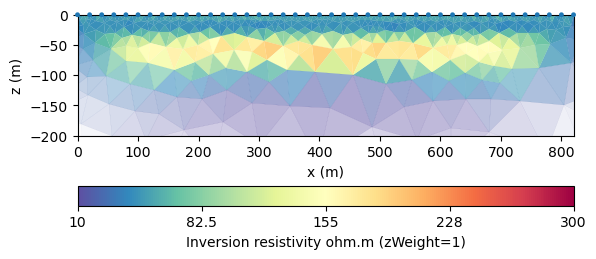

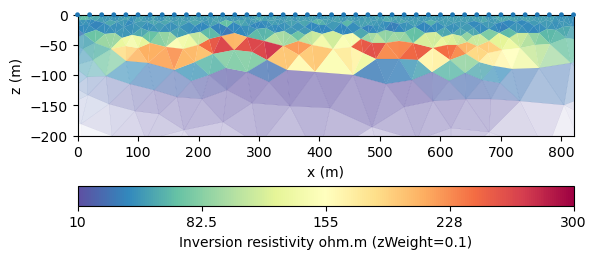

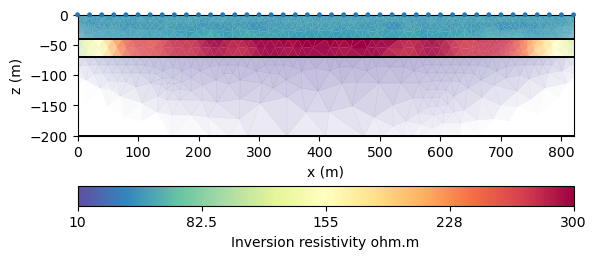

In [11]:
kwargs = {'xlabel':"x (m)", 'ylabel':"z (m)", 'cMap':"Spectral_r", 'cMin':10, 'cMax':300, 'logScale':False}

ax, _ = pg.show(mesh, data=rhomap, showMesh=False, label="Model Resistivity ohm.m", **kwargs)
ax.set_xlim(min(elecs), max(elecs));
ax.set_ylim(-10*spacing, 0);

ax, _ = mgr.showResult(inv, label="Inversion resistivity ohm.m (zWeight=1)",**kwargs)
ax.set_xlim(min(elecs), max(elecs));
ax.set_ylim(-10*spacing, 0);

ax, _ = mgr.showResult(invLowz, label="Inversion resistivity ohm.m (zWeight=0.1)",**kwargs)
ax.set_xlim(min(elecs), max(elecs));
ax.set_ylim(-10*spacing, 0);

ax, _ = mgrConstrained.showResult(label="Inversion resistivity ohm.m",**kwargs)
ax.set_xlim(min(elecs), max(elecs));
ax.set_ylim(-10*spacing, 0);